import nessary libraries

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from functools import cmp_to_key
from scipy.ndimage import interpolation as inter
from contour_sort import *
from crop_image import *
from paper_extraction import *
from commonfunctions import *

In [2]:
def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        #if area > 1000:
        peri = cv2.arcLength(i, True)
        approx = cv2.approxPolyDP(i, 0.015 * peri, True)
        if area > max_area and len(approx) == 4:
            biggest = approx
            max_area = area
    return biggest

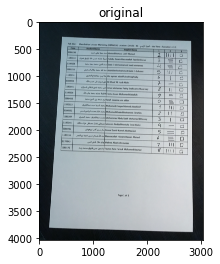

In [3]:
img = cv2.imread('../../15.jpg')
show_images([img], ['original'])

img_original = img.copy()

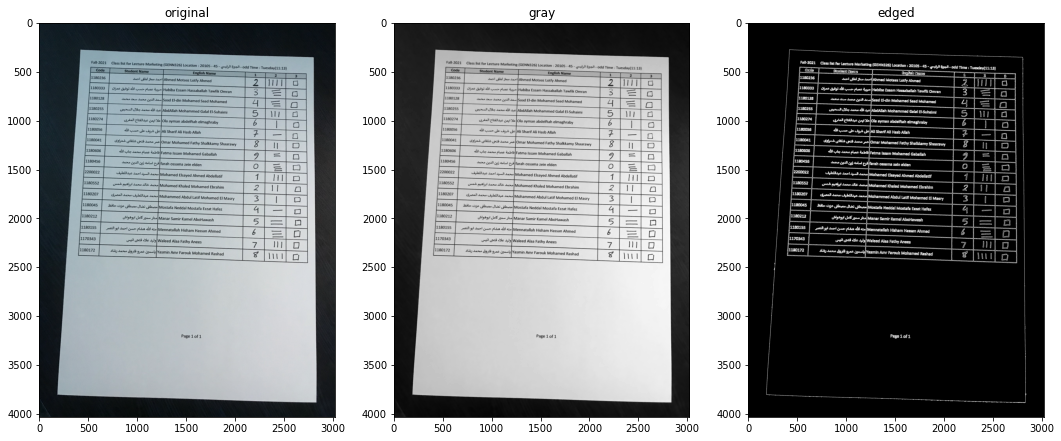

In [4]:
# Image modification
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 20, 30, 30)

edged = cv2.Canny(gray, 20, 120)
edged = cv2.dilate(edged.copy(), None, 1)
show_images([img, gray, edged], ['original', 'gray','edged'])


In [5]:
contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
for c in contours:
    cv2.drawContours(img, [c], -1, (0, 255, 0), 3) #######################################


In [6]:
biggest = biggest_contour(contours)

#cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)

In [7]:
points = biggest.reshape(4, 2)
input_points = np.zeros((4, 2), dtype="float32")

In [8]:
points_sum = points.sum(axis=1)
input_points[0] = points[np.argmin(points_sum)]
input_points[3] = points[np.argmax(points_sum)]

points_diff = np.diff(points, axis=1)
input_points[1] = points[np.argmin(points_diff)]
input_points[2] = points[np.argmax(points_diff)]


In [9]:
(top_left, top_right, bottom_right, bottom_left) = input_points
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

In [10]:
# Output image size
max_width = max(int(bottom_width), int(top_width))

# max_height = max(int(right_height), int(left_height))
max_height = int(max_width * 1.414)  # for A4

# Desired points values in the output image
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

In [11]:
# Perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

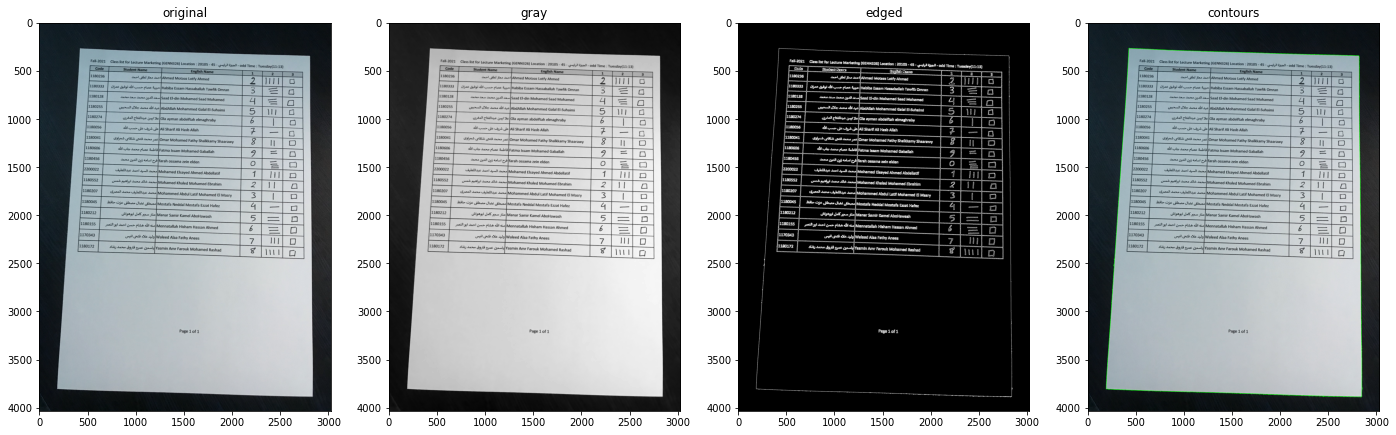

In [12]:
show_images([img_original, gray, edged, img], ['original','gray','edged','contours'])


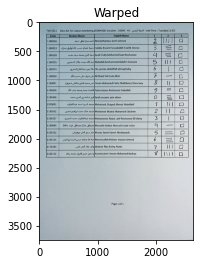

In [13]:
show_images([img_output], ['Warped'])

In [14]:
# img = cv2.imread('../../4.jpg')
# paper=extract_the_paper_from_image(img)

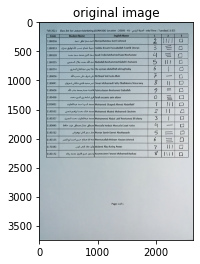

In [15]:
# img =paper.astype("uint8")
img= img_output.copy()
show_images([img],['original image'])

In [16]:
# Thresholding the image
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
(thresh, img_bin) = cv2.threshold(img, 128, 255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)

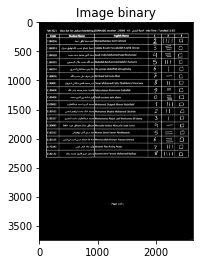

In [17]:
# Invert the image
img_bin = 255-img_bin 
show_images([img_bin],['Image binary'])

In [19]:
# Defining a kernel length
kernel_length = np.array(img).shape[1]//150
 
# A verticle kernel of (1 X kernel_length), which will detect all the verticle lines from the image.
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_length))

# A horizontal kernel of (kernel_length X 1), which will help to detect all the horizontal line from the image.
hori_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_length, 1))

# A kernel of (3 X 3) ones.
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

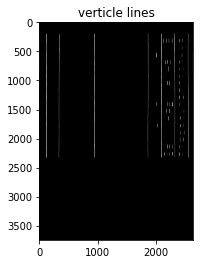

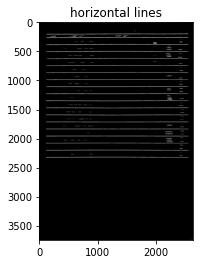

In [20]:
# Morphological operation to detect vertical lines from an image
img_temp1 = cv2.erode(img_bin, verticle_kernel, iterations=3)
verticle_lines_img = cv2.dilate(img_temp1, verticle_kernel, iterations=3)
show_images([verticle_lines_img],['verticle lines'])

# Morphological operation to detect horizontal lines from an image
img_temp2 = cv2.erode(img_bin, hori_kernel, iterations=3)
horizontal_lines_img = cv2.dilate(img_temp2, hori_kernel, iterations=3)
show_images([horizontal_lines_img],['horizontal lines'])

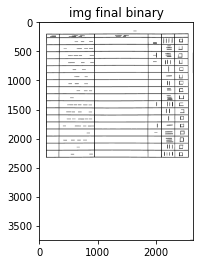

In [21]:
# Weighting parameters, this will decide the quantity of an image to be added to make a new image.
alpha = 0.5
beta = 1.0 - alpha

# This function helps to add two image with specific weight parameter to get a third image as summation of two image.
img_final_bin = cv2.addWeighted(verticle_lines_img, alpha, horizontal_lines_img, beta, 0.0)
img_final_bin = cv2.erode(~img_final_bin, kernel, iterations=2)
(thresh, img_final_bin) = cv2.threshold(img_final_bin, 128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
show_images([img_final_bin],['img final binary'])

In [22]:
contours,im2 = cv2.findContours(img_final_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cmp_to_key(contour_sort))
boundingBoxes = [cv2.boundingRect(c) for c in contours]
(cnts, boundingBoxes) = zip(*sorted(zip(contours, boundingBoxes), key=lambda b:b[1][0]))

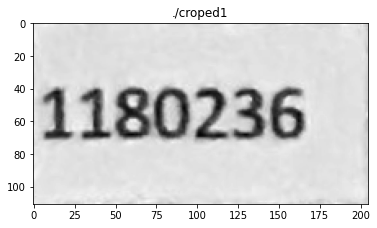

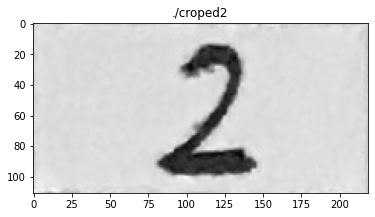

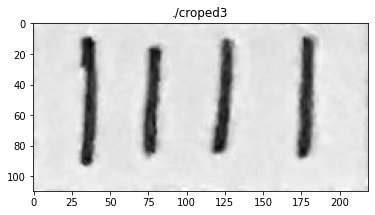

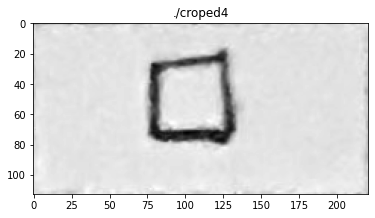

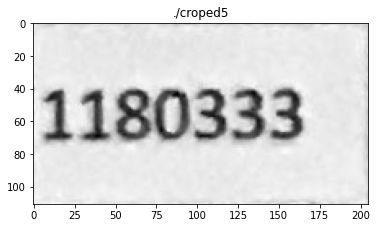

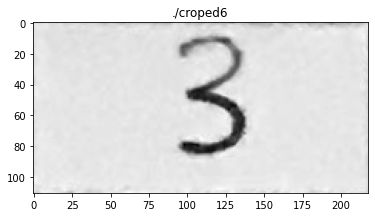

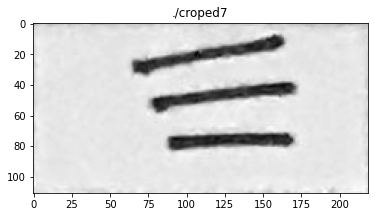

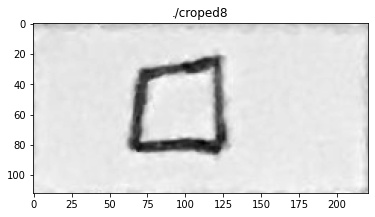

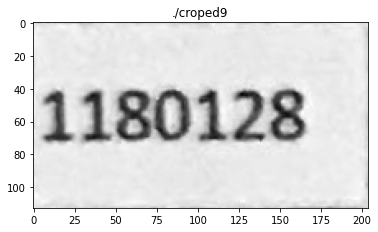

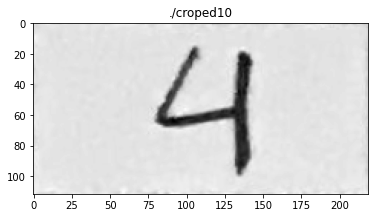

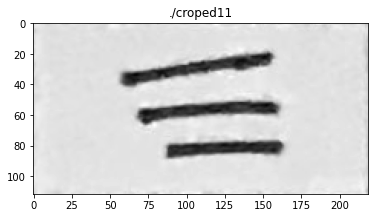

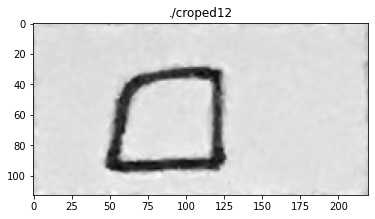

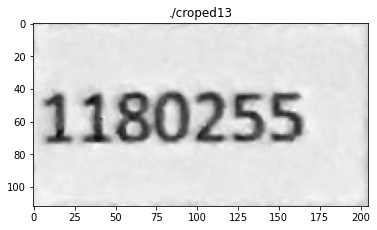

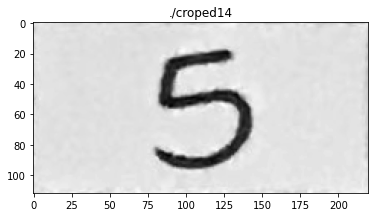

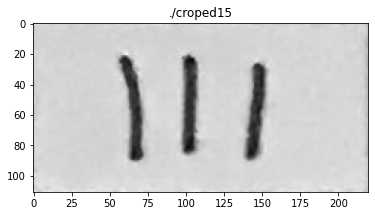

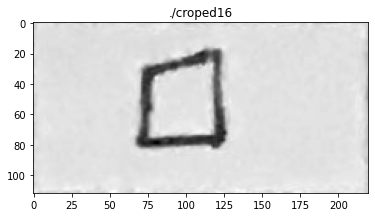

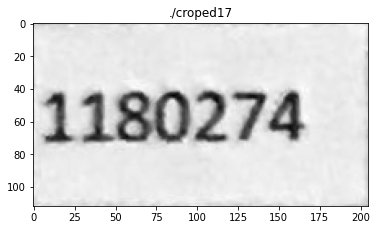

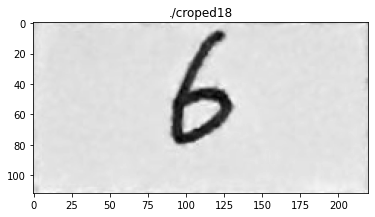

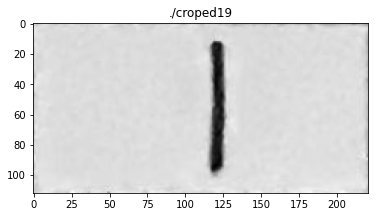

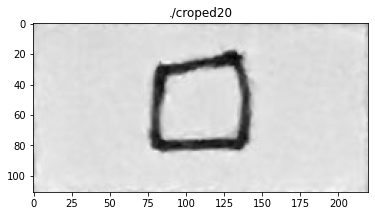

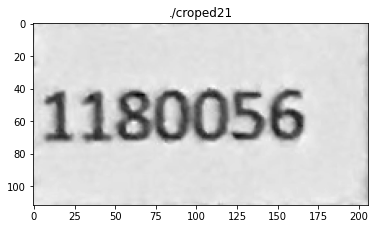

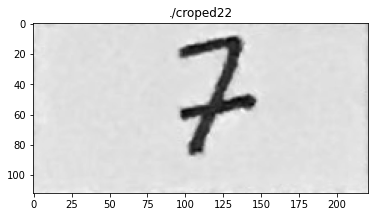

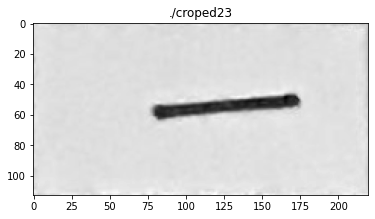

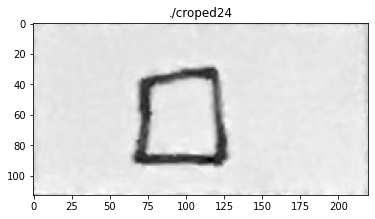

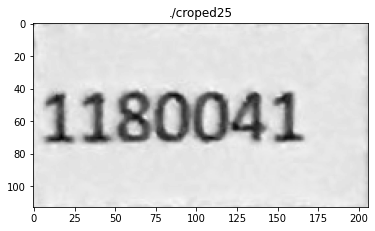

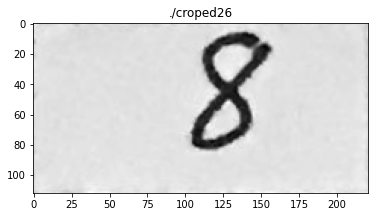

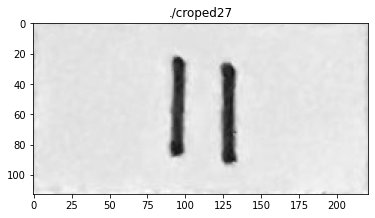

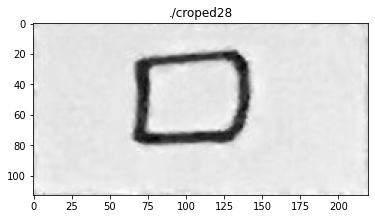

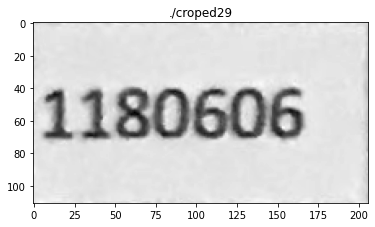

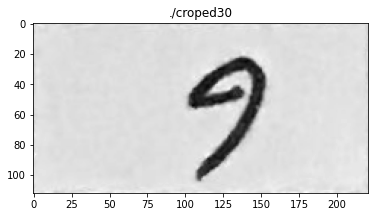

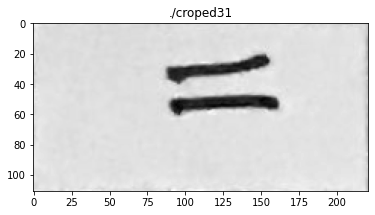

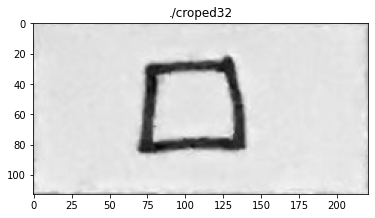

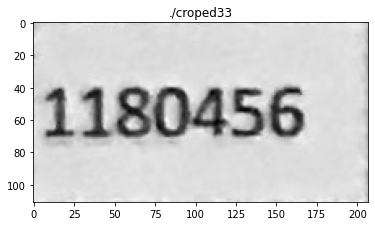

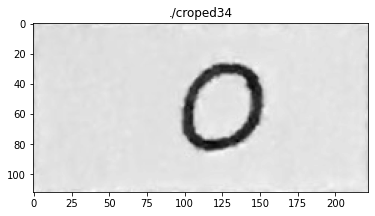

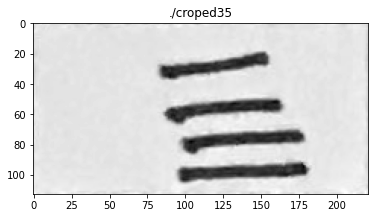

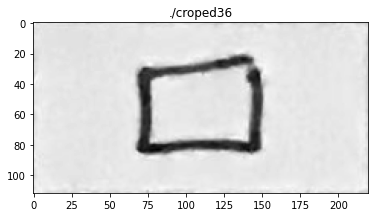

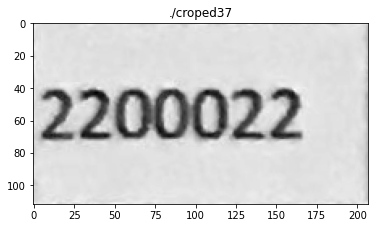

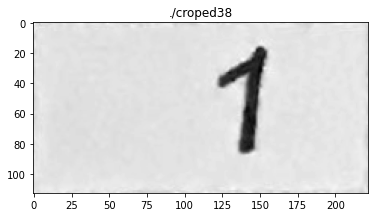

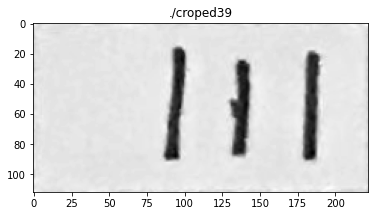

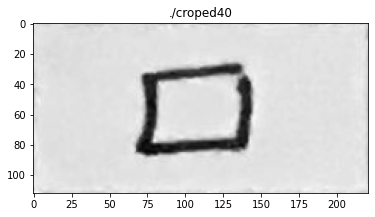

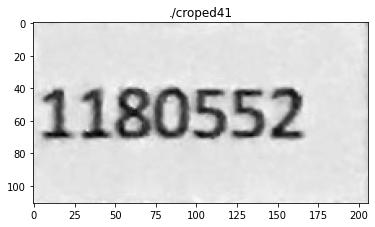

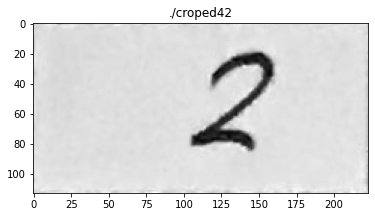

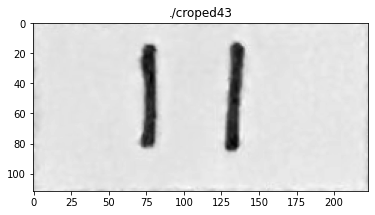

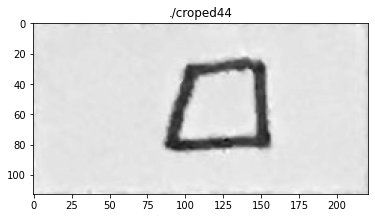

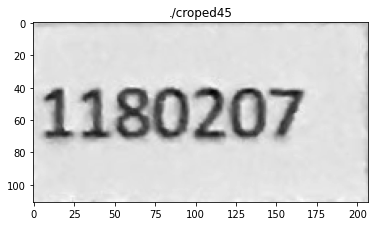

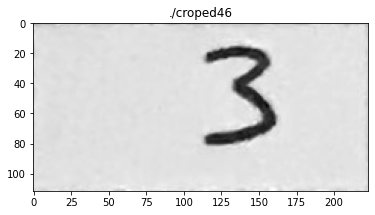

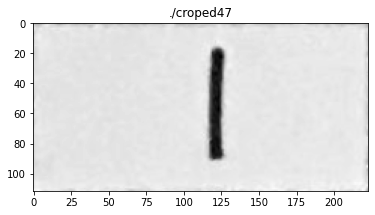

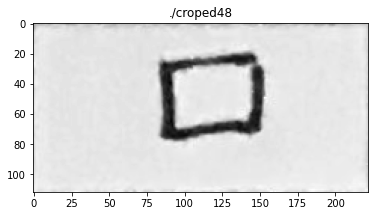

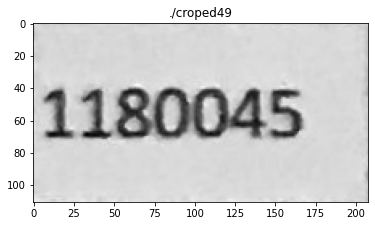

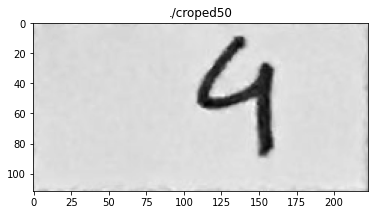

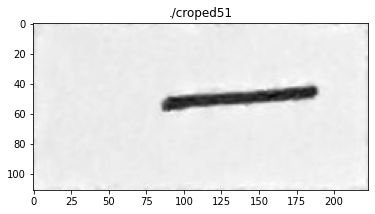

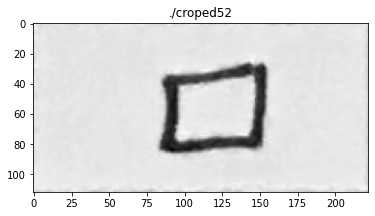

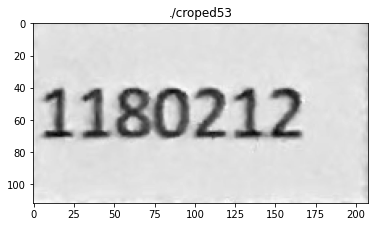

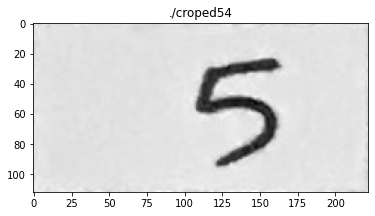

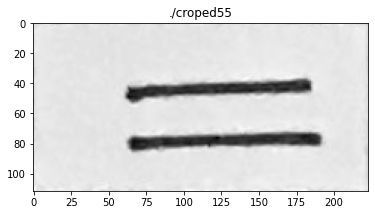

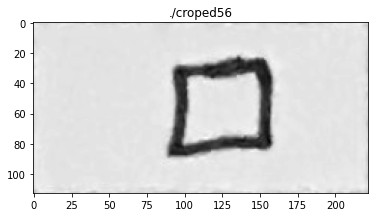

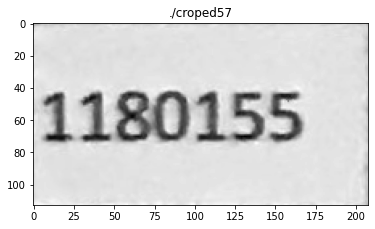

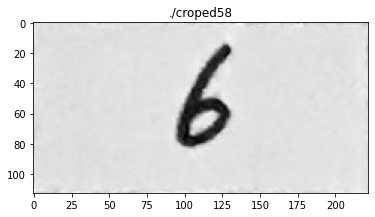

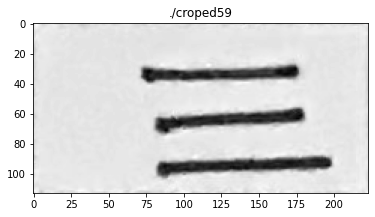

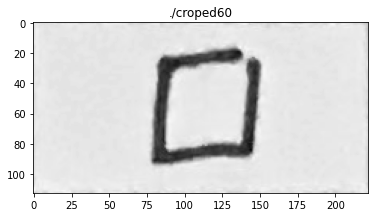

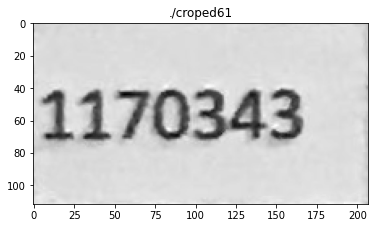

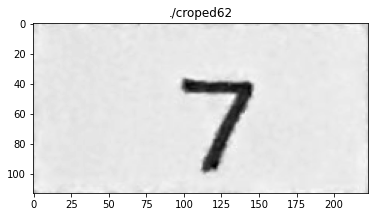

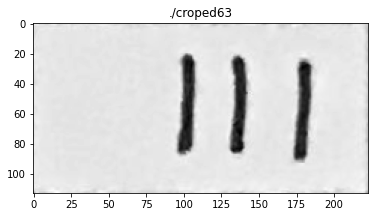

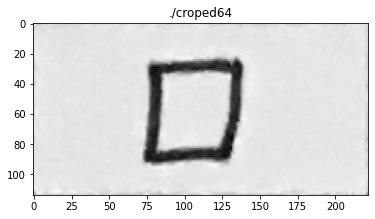

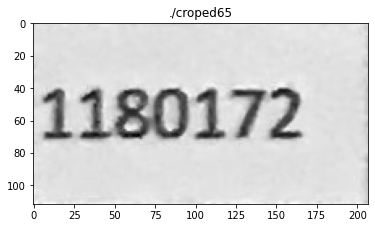

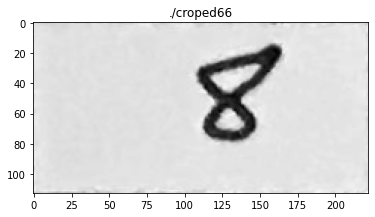

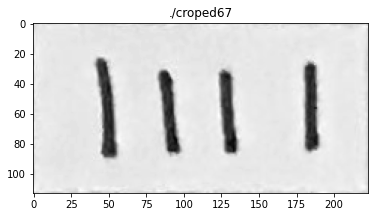

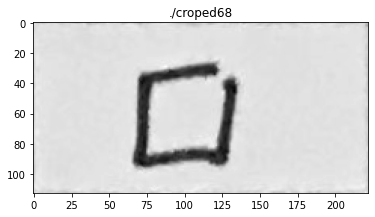

In [23]:
idx = 0
for c in contours:
        # Returns the location and width,height for every contour
        x, y, w, h = cv2.boundingRect(c)
# If the box height is greater then 20, widht is >80, then only save it as a box in "cropped/" folder.
        if (w > 100 and w < 250 and h > 100) and w > h:
            idx += 1
            new_img = img[y:y+h, x:x+w]

            show_images([new_img],['./croped'+str(idx)])